In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('train.parquet')

In [3]:
df.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


У нас данные состоят из дат и значений. попробуем придумать новые признаки

Так же приведем все значения к массивам одной длины и разделим на отдельные колонки

In [4]:
def calculate_timespan_and_avg_period(dates): # Для рассчета длительности периода и сренего шага между датами
    if len(dates) < 2:
        return pd.Series([0, 0])  # Если меньше двух дат, возвращаем 0
    first_date = dates[0]
    last_date = dates[-1]
    timespan = (last_date - first_date).total_seconds() / (3600 * 24) # Разница в в днях
    differences = [(dates[i] - dates[i - 1]).total_seconds() / 3600 for i in range(1, len(dates))]
    avg_period = sum(differences) / len(differences) if differences else 0  # Средняя разница в часах
    return pd.Series([timespan, avg_period])

In [5]:
def create_features(dF):
    df = pd.DataFrame()
    df['length'] = dF['dates'].apply(len) # Длина начального временного ряда
    df['mean'] = dF['values'].apply(np.mean) # Среднее значение
    df['std'] = dF['values'].apply(np.std) # Среднее отклонение
    df['max'] = dF['values'].apply(np.max) 
    df['min'] = dF['values'].apply(np.min)
    df['median'] = dF['values'].apply(np.median)
    df['trend'] = dF['values'].apply(lambda x: x[-1] - x[0]) # Разница между начальным и конечным значением
    df[['timespan', 'avg_period']] = dF['dates'].apply(calculate_timespan_and_avg_period) # Считаем в функции в ячейке выше
    # df['weight'] = df['timespan'] * df['mean']
    

    perfect_len = df['length'].quantile(0.75) # Возьмем эталонной длину такую, чтобы только 25% рядов пришлось обрезать
    def perfectify_list(array = np.array): # Приводим к эталонной длине
        if len(array) > perfect_len: # Если начальная длина больше эталонной, 
            diff = (len(array) - perfect_len)
            perfect_array = array[int(diff):] # обрезаем первые члены
            return perfect_array
        if len(array) < perfect_len: # Если же меньше,
            diff = - (len(array) - perfect_len)
            perfect_array = np.concatenate((np.array([array[0]] * int(diff)), array)) # То добавляем в начало первый член столько раз, чтоб получился массив нужной длины
            return perfect_array
        return array
    
    # Найдем месяц и год старта и конца временного ряда
    df['start_month'] = dF['dates'].apply(lambda x: x[0].month)
    df['start_year'] = dF['dates'].apply(lambda x: x[0].year)

    df['end_month'] = dF['dates'].apply(lambda x: x[-1].month)
    df['end_year'] = dF['dates'].apply(lambda x: x[-1].year)

    # Разобъем 'идеализированные' массивы на колонки
    values_columns = pd.DataFrame(dF['values'].apply(perfectify_list).tolist(), index=df.index)
    values_columns.columns = [f'value_{i}' for i in range(values_columns.shape[1])]

    # Все в один массив
    df = pd.concat([values_columns, df], axis=1)
    df['label'] = dF['label']

    # Возвращаем конечный массив и эталонную длину
    return df, perfect_len


In [6]:
features, length_of_series = create_features(df)
features.head()


,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,...,min,median,trend,timespan,avg_period,start_month,start_year,end_month,end_year,label
0,-1.86,-1.86,-1.86,-1.86,-1.86,-1.86,-1.86,-1.86,-1.86,-1.86,...,-4.840000,-0.110000,1.290000,1858.0,731.016393,1,2016,2,2021,0.0
1,-1.04,-1.04,-1.04,-1.04,-1.04,-1.04,-1.04,-1.04,-1.04,-1.04,...,-3.534409,-0.274409,0.985591,1340.0,730.909091,5,2016,1,2020,1.0
2,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,0.28,...,-1.950000,-0.145000,-0.700000,1433.0,731.744681,3,2017,2,2021,0.0
3,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,...,-2.220000,-0.345000,1.920000,1430.0,730.212766,1,2016,12,2019,0.0
4,1.31,1.31,1.31,1.31,1.31,1.31,1.31,1.31,1.31,1.31,...,-2.500000,-0.475000,-2.060000,1674.0,730.472727,1,2016,8,2020,0.0


Понимаем, что средний шаг у всех рядов почти одинаковый

In [7]:
features['avg_period'].describe()

count    80000.000000
mean       730.409463
std          0.336535
min        729.081081
25%        730.181818
50%        730.400000
75%        730.615385
max        732.342857
Name: avg_period, dtype: float64

Поэтому удаляем

In [8]:
features = features.drop('avg_period', axis = 1)

In [9]:
# Все добавленные признаки
time_series_features = ['length', 'mean', 'std', 'max', 'min', 'median', 'timespan',
                        'trend', 'start_month', 'start_year', 'end_month', 'end_year']

Посмотрим на распределения добавочных признаков по классам

In [10]:
class_1 = features.query('label == 1.0').copy()
class_0 = features.query('label == 0.0').copy()

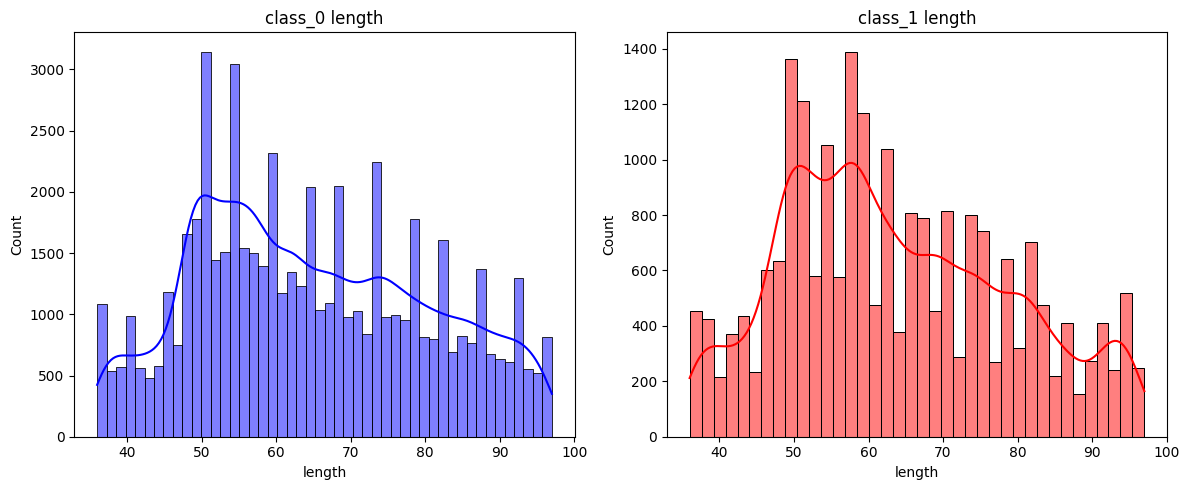

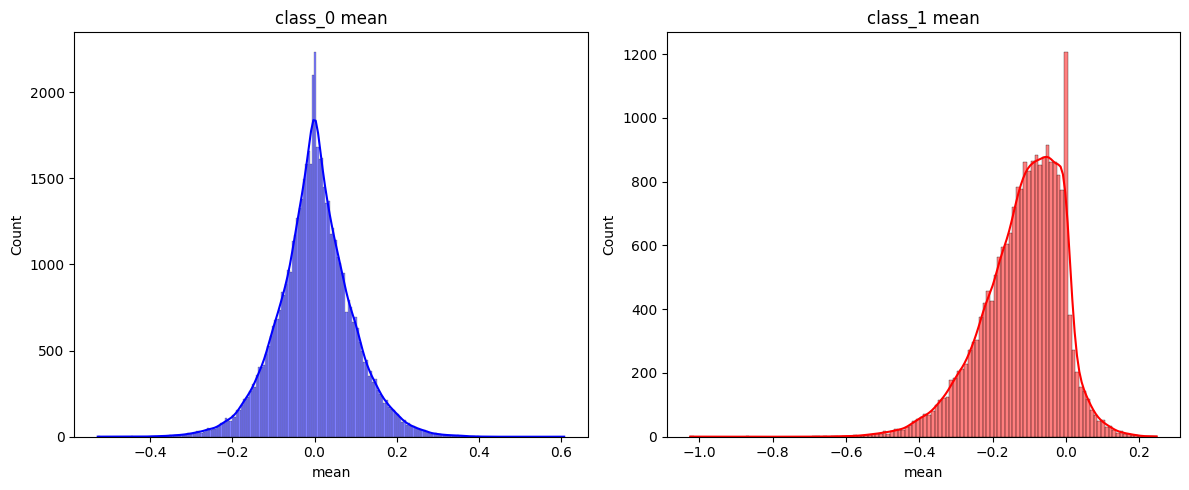

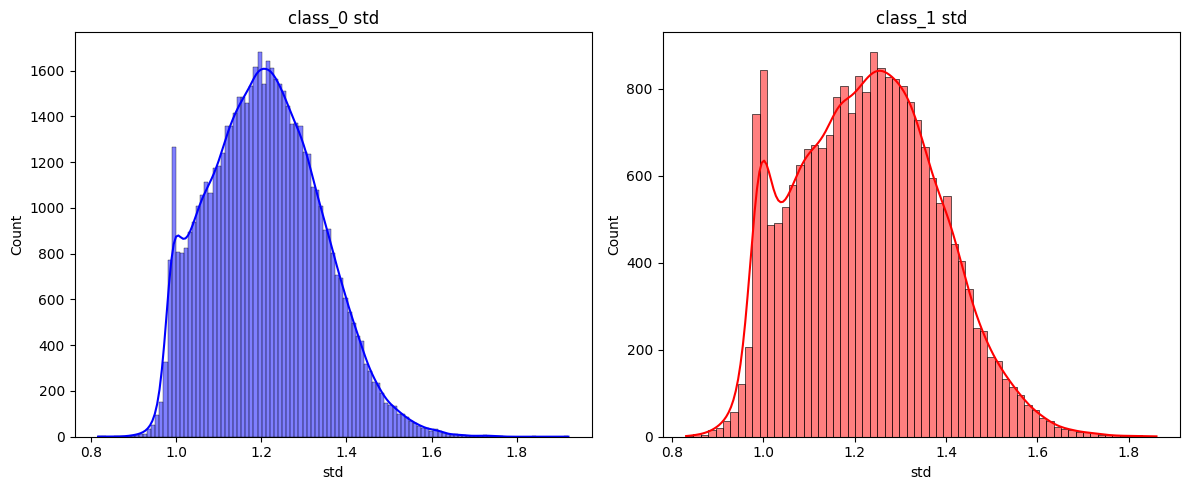

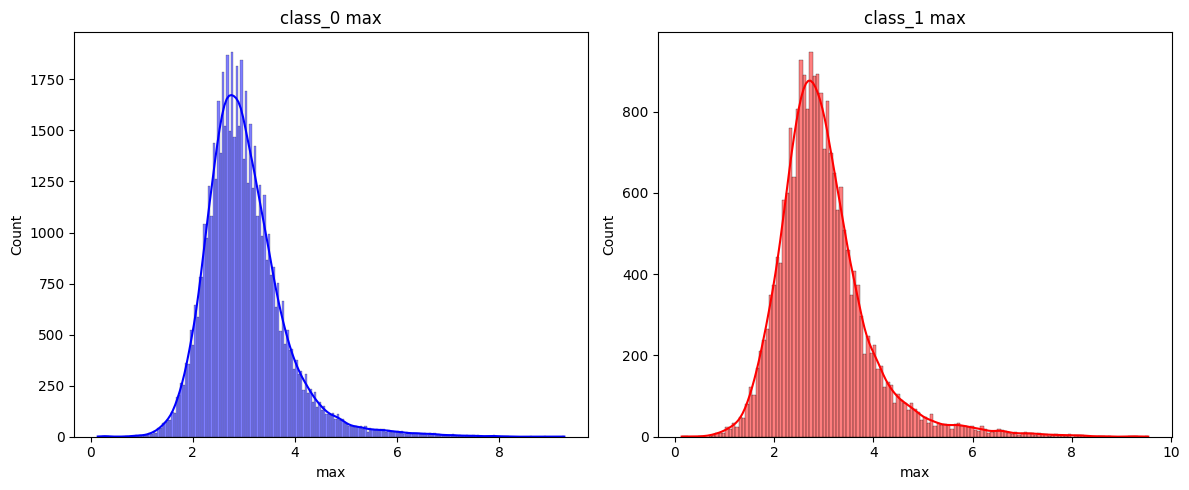

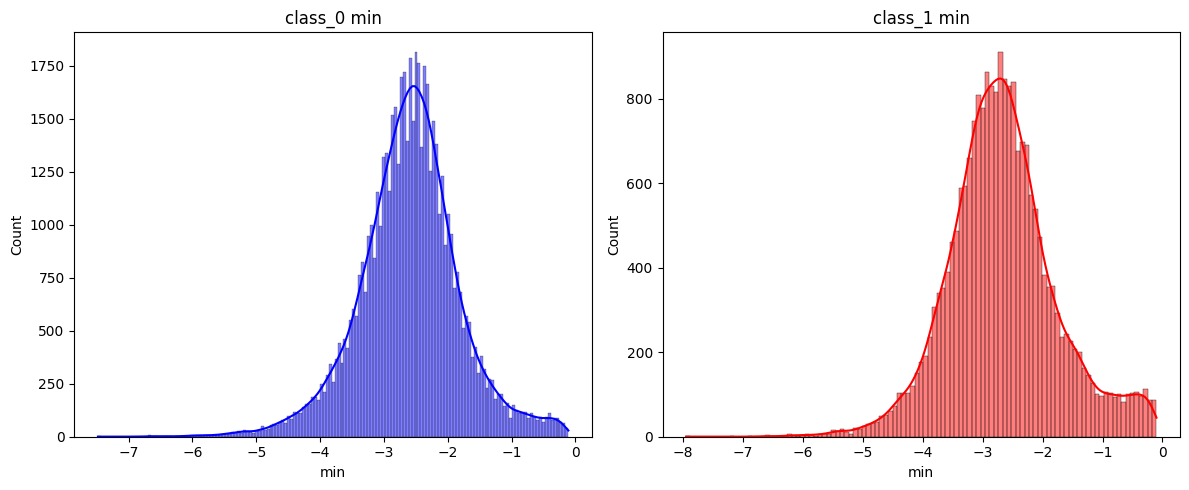

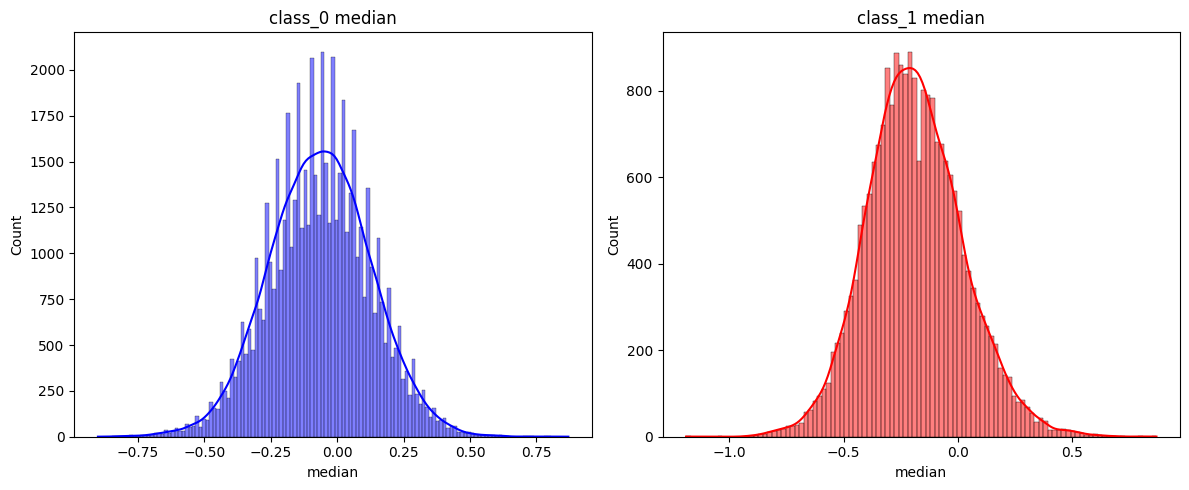

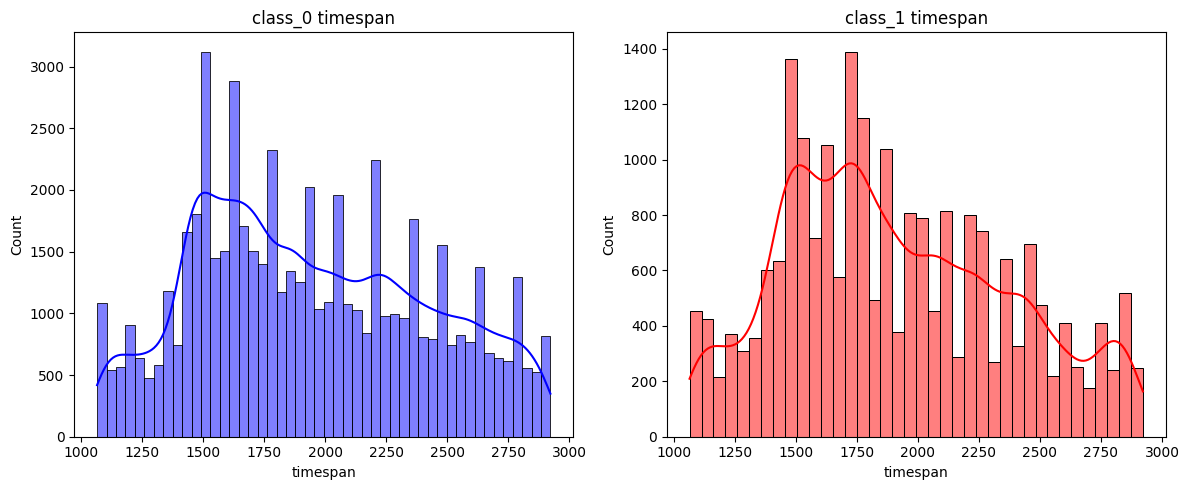

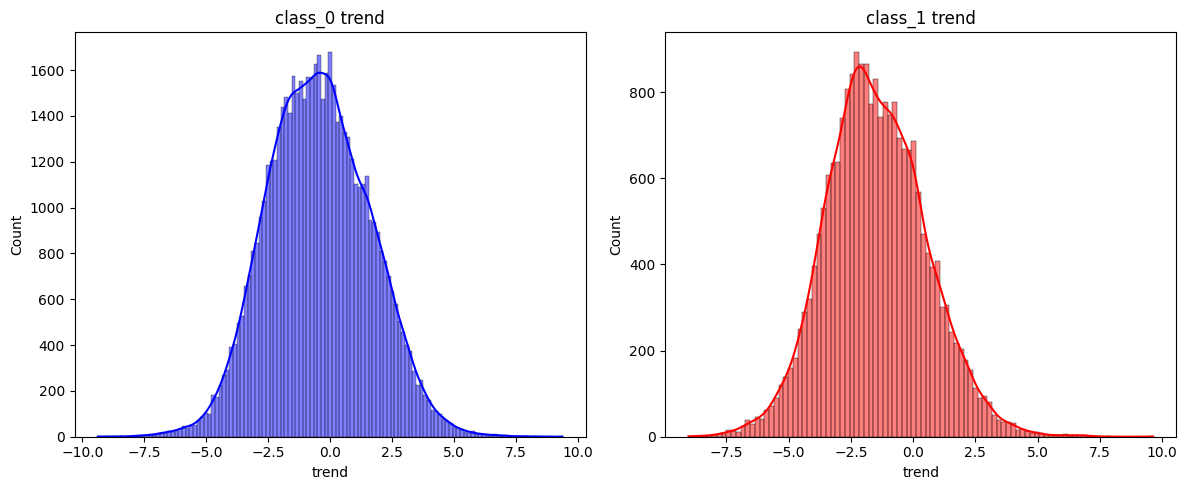

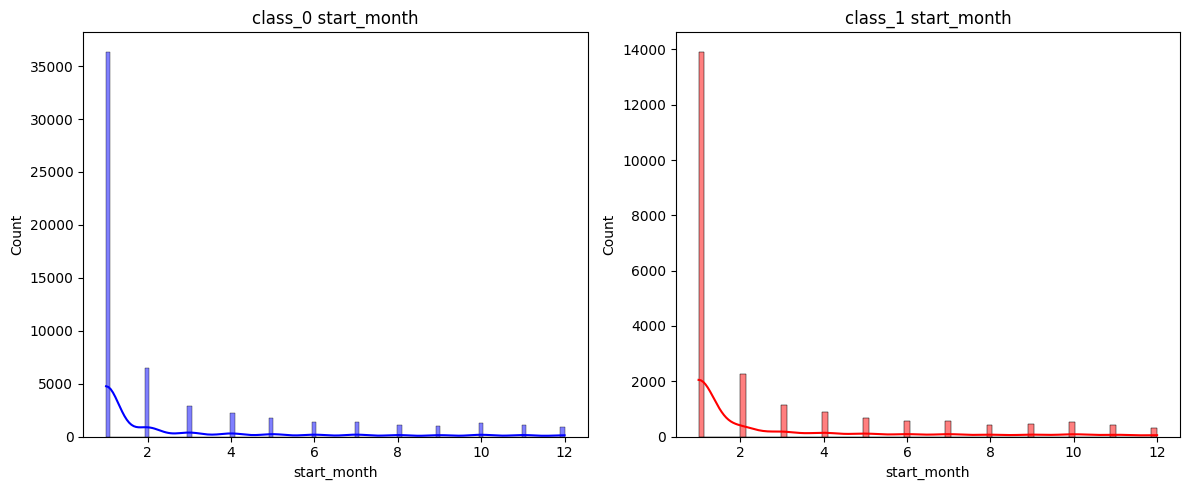

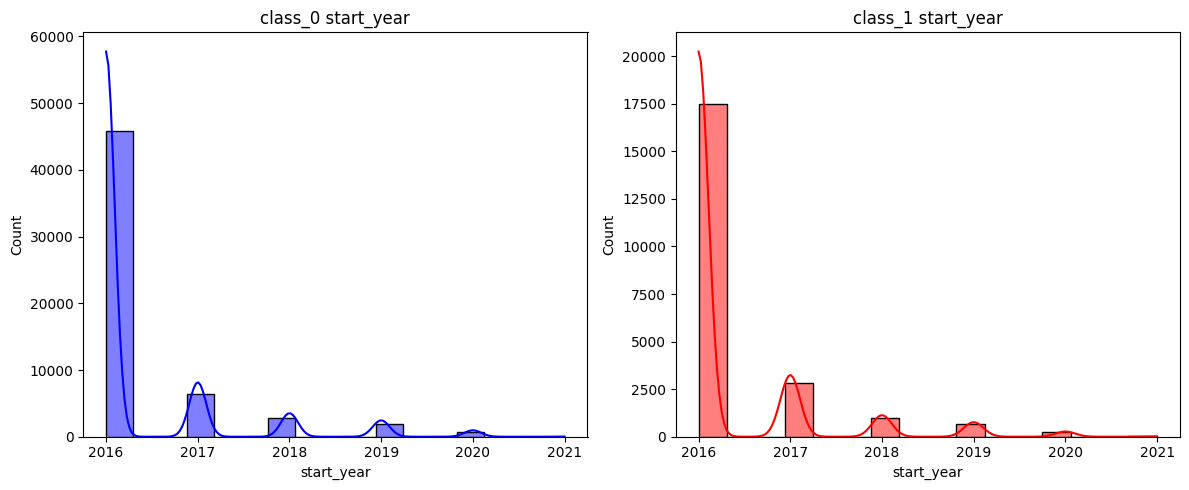

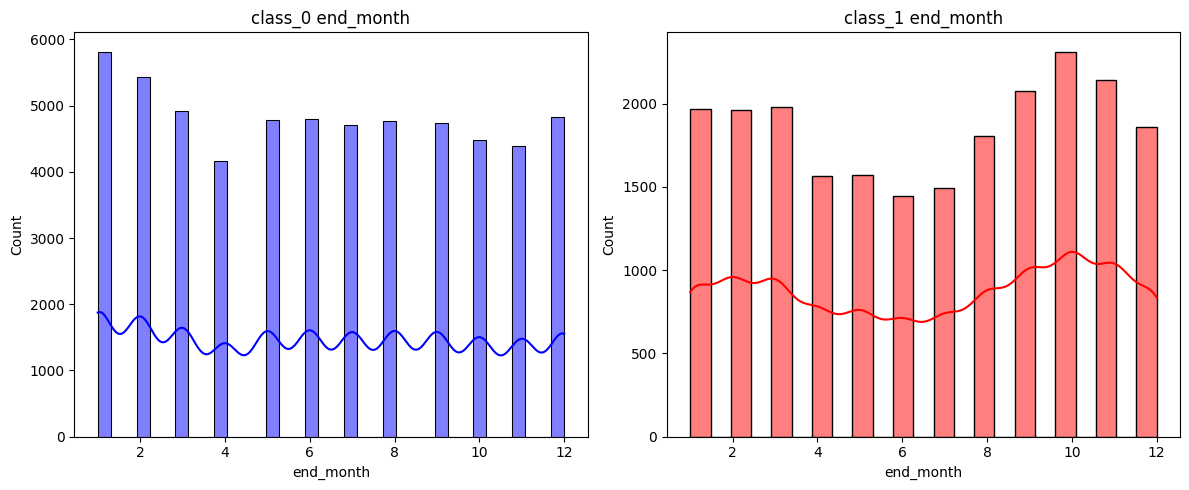

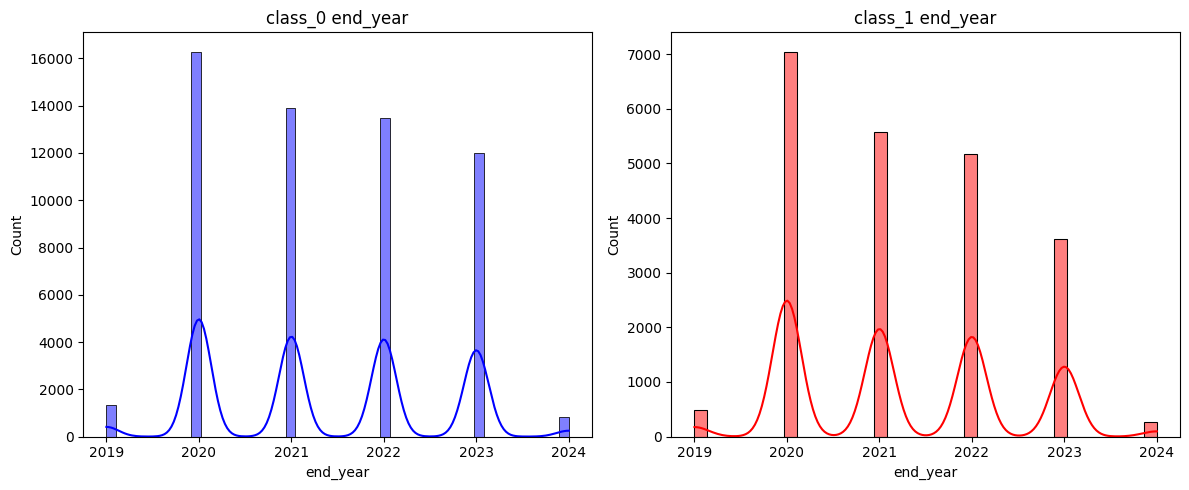

In [11]:
# plt.subplots(len(time_series_features), 1)
cnt = 0
for feature in time_series_features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(class_0[feature], kde = True, ax = axes[0], color = 'b')
    sns.histplot(class_1[feature], kde = True, ax = axes[1], color = 'r')
    axes[0].set_title('class_0 ' + feature)
    axes[1].set_title('class_1 ' + feature)
    cnt += 1
    plt.tight_layout()
    plt.show()

И посмотрим на корреляционную матрицу

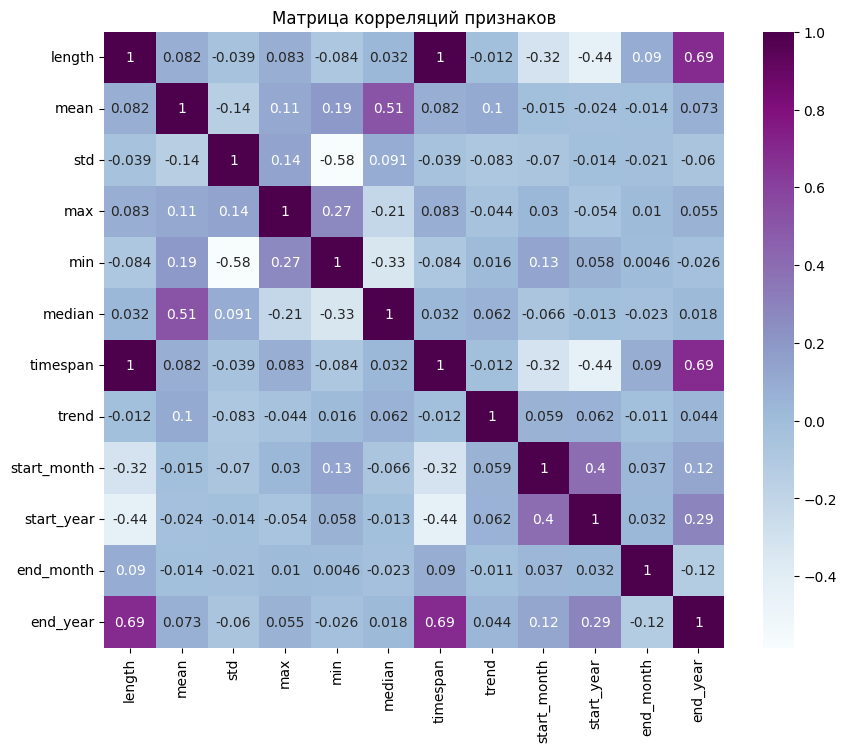

In [12]:
df_corr = features[time_series_features]
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='BuPu')
plt.title('Матрица корреляций признаков')
plt.show()

Как видно на тепловой карте, продолжительность временного ряда ОЧЕНЬ сильно коррелирует с длиной начального ряда, что логично,
так как ранее мы выяснили, что средний шаг одинаковый для всех рядов

Поэтому тоже удаляем

In [13]:
features = features.drop('timespan', axis = 1)

Воспользуемся классификатором от xgboost

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

import xgboost as xgb

Делим на тренировочную и тестовые выборки

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features.drop('label', axis = 1), features['label'], test_size=0.2, random_state=42)

In [16]:
X_train

,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,...,mean,std,max,min,median,trend,start_month,start_year,end_month,end_year
3822,-1.34,-1.34,-1.34,-1.34,-1.34,-1.34,-1.34,-1.34,-1.34,-1.34,...,-0.038254,1.039811,2.360000,-1.605180,0.230000,0.074820,12,2016,10,2021
35562,2.64,2.64,2.64,2.64,1.49,0.75,-1.39,-0.09,-0.16,3.43,...,0.101918,1.276316,3.430000,-3.310000,0.130000,-4.050000,2,2016,2,2022
4883,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,...,0.087667,1.308964,2.380000,-2.470000,0.050000,0.240000,1,2016,12,2020
71170,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,0.12,...,-0.053667,1.138941,2.530000,-2.370000,0.000000,-1.300000,11,2018,10,2023
25665,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23,3.23,...,0.264681,1.487195,3.230000,-2.730000,0.380000,-5.200000,6,2016,4,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,-0.79,-0.79,-0.79,-0.79,-0.79,-0.79,-0.79,-0.79,-0.79,-0.79,...,0.041458,1.451521,3.120000,-3.800000,0.100000,1.410000,1,2016,12,2019
54886,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,1.36,...,0.037899,1.408549,4.280000,-2.630000,-0.030000,-1.191879,1,2016,2,2020
76820,1.24,1.24,1.24,1.24,1.24,1.24,1.24,1.24,1.24,1.24,...,-0.083871,1.252835,3.150000,-3.280000,-0.285000,-0.800000,1,2016,2,2021
860,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,...,-0.274674,1.325545,2.590000,-2.894863,-0.524863,-3.854863,7,2020,7,2023


И обучаем классификатор на тренировочной

In [17]:
clf =  xgb.XGBClassifier(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='binary:logistic',
                       max_depth=4,
                       learning_rate=0.01,
                       eval_metric = 'rmse')
clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:0.49763	validation_1-rmse:0.49764
[100]	validation_0-rmse:0.37265	validation_1-rmse:0.37441
[200]	validation_0-rmse:0.34078	validation_1-rmse:0.34457
[300]	validation_0-rmse:0.32873	validation_1-rmse:0.33361
[400]	validation_0-rmse:0.32122	validation_1-rmse:0.32720
[500]	validation_0-rmse:0.31584	validation_1-rmse:0.32286
[600]	validation_0-rmse:0.31174	validation_1-rmse:0.31971
[700]	validation_0-rmse:0.30854	validation_1-rmse:0.31741
[800]	validation_0-rmse:0.30589	validation_1-rmse:0.31559
[900]	validation_0-rmse:0.30357	validation_1-rmse:0.31411
[999]	validation_0-rmse:0.30158	validation_1-rmse:0.31288


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Важность признаков, с большим отрывом первый по важности признак - среднее значение

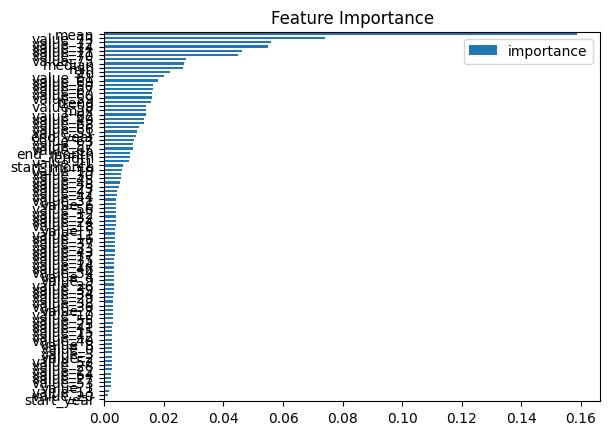

In [18]:
fi = pd.DataFrame(data=clf.feature_importances_,
             index=clf.feature_names_in_,
             columns=['importance'])
# fi = fi[time_series_features]
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Возьмем вероятности принадлежности к каждому классу

In [19]:
label_predict_proba = clf.predict_proba(X_test)

In [20]:
label_predict_proba

array([[0.91680926, 0.08319075],
       [0.74092054, 0.25907946],
       [0.88255954, 0.11744045],
       ...,
       [0.92678356, 0.07321644],
       [0.6776171 , 0.32238296],
       [0.71321154, 0.2867885 ]], dtype=float32)

И возьмем границу 0.5

In [21]:
y_pred = [1 if prob[1] > 0.5 else 0 for prob in label_predict_proba]

Смотрим roc_auc

In [22]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

0.8046128509741143

In [23]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.91     11607
         1.0       0.79      0.68      0.73      4393

    accuracy                           0.86     16000
   macro avg       0.84      0.80      0.82     16000
weighted avg       0.86      0.86      0.86     16000



Довольно хороший резульат, обучим модель на всех данных

In [24]:
final_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       objective='binary:logistic',
                       max_depth=4,
                       learning_rate=0.01,
                       eval_metric = 'rmse')
final_clf.fit(features.drop('label', axis = 1), features['label'],
        verbose=100)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='rmse', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
import joblib

Сохраним модель и эталонный размер ряда для обработки тестовых данных в другом ноутбуке

In [26]:
needed_files = [length_of_series, final_clf]

In [27]:
joblib.dump(needed_files, 'model_and_size.joblib')

['model_and_size.joblib']